<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_17_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте немного отвлечемся от тяжелых будней будущего нейронщика и вспомним, что в мире есть маленькие радости - а именно мультяшки. 

В этой работе: 
- скачайте датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip
- обучите VAE на данном датасете
- посмотрите качество воспроизведения мультяшек
- нагенерите мультяшек на свой вкус - оцените работу декодера


In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image 

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose

import keras.backend as K

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir cartoonset

In [ ]:
!tar -xzvf /content/drive/MyDrive/data/cartoonset10k.tgz -C /content/cartoonset

In [ ]:
path = '/content/cartoonset/cartoonset10k'

In [ ]:
data_files = []                           
                         
for file_name in os.listdir(path):   
    if file_name.split('.')[-1] == 'png':
    
      data_files.append(f'{path}/{file_name}')

print('Общий размер базы для обучения:', len(data_files))

Общий размер базы для обучения: 10000


In [ ]:
img = Image.open(path+'/cs10000053986926948907.png') # посмотрим одну картинку
    
img_np = np.array(img)   
print(img_np.shape)

(500, 500, 4)


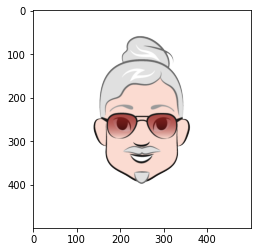

In [ ]:
plt.imshow(img_np)

картинки имеют размер 500 на 500 на прозрачном фоне (4 канала), уменьшаю, так как колаб вырубается

In [ ]:
IMG_WIDTH = 128                          
IMG_HEIGHT = 128               

In [ ]:
data_images = []                          

for file_name in data_files:
    
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT)) 
    img_np = np.array(img)
    #B, G, R, _ = img_np.T
    #img_rgb = np.array((B, G, R)).T             
    data_images.append(img_np)            

x_data = np.array(data_images)            


print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')

В массив собрано 10000 фотографий следующей формы: (128, 128, 4)
Общий массив данных изображений следующей формы: (10000, 128, 128, 4)


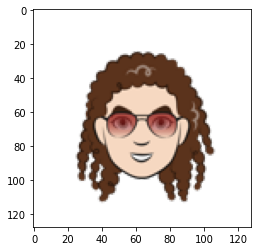

In [ ]:
plt.imshow(x_data[1])

In [ ]:
hidden_dim = 8  # Зададим размерность скрытого пространства AE

batch_size = 64 # Зададим размер батча для обучения AE(должно быть кратно 10 000)

In [ ]:
# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


In [ ]:
# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x

In [ ]:
x_data[0].shape

(128, 128, 4)

### Сверточный VAE


In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = x_data / 255. 
 

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 128, 128, 4))  


In [ ]:
hidden_dim = 8
batch_size = 64    
#Alpha channel:   

In [ ]:
# Создадим сверточный энкодер

input_img = Input(shape=(128, 128, 4))                     # Добавим входной слой
x = encoderBlock(input_img, neu=32, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)
x = encoderBlock(x, neu=64, kernel=3, strides=2)
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=1)         # Добавим 4-й блок свертка+нормализация+активашка
flatten =Flatten()(x)                                    # Добавим Flatten
x = Dense(2, activation='linear')(flatten)               # Здесь можно увеличивать, попробовать 100,200 Добавим выходной dense слой

In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания. 200
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                           # На выходе - тензор случайных чисел 

In [ ]:
 # Соберем энкодер

encoderVAEС = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=(hidden_dim,))                            # Добавим входной слой
x = Dense(8*8*64, name='dense_1')(input_enc)               # Добавим dense в 8х8х64 = 3136 нейронами
x = Reshape((8, 8, 64))(x)                               # Решейпим 1D тензор в 3D тензор
x= decoderBlock(x, neu=64, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=64, kernel=3, strides=2)
x= decoderBlock(x, neu=64, kernel=3, strides=2)
x= decoderBlock(x, neu=64, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=32, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(4, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)# Добавим выходной слой

In [ ]:
# Соберем декодер

decoderVAEС = keras.Model(input_enc, decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAEС(encoderVAEС(input_img)[2]) 

In [ ]:
# Соберем наши сетки

vaec = keras.Model(input_img, decoderVAEС(encoderVAEС(input_img)[2])) # Соберем VAE

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 128*128                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
vaec.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Выведем состав энкодера
encoderVAEС.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 32  1184        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 128, 128, 32  128        ['conv2d_6[0][0]']               
 ormalization)                  )                                                           

In [ ]:
#  Выведем состав энкодера
decoderVAEС.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 4096)              36864     
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 8, 8, 64)         36928     
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 8, 8, 64)          0   

In [ ]:
# Компилируем VAE

vaec.compile(optimizer='adam') # оптимайзер ADAM

In [ ]:
# Запускаем обучениe

vaec.fit(x_train,      # Обучающая выборка
        x_train,       # "Labels" обучающей выборки
        epochs=10,      # 10 эпох
        batch_size=60, # размер батча
        shuffle=True)  # обучающую выборку перемешиваем


Epoch 1/10
167/167 [==============================] - 21s 125ms/step - loss: 178.3103
Epoch 2/10
167/167 [==============================] - 21s 125ms/step - loss: 178.1711
Epoch 3/10
167/167 [==============================] - 21s 125ms/step - loss: 177.2049
Epoch 4/10
167/167 [==============================] - 21s 125ms/step - loss: 174.1746
Epoch 5/10
167/167 [==============================] - 21s 125ms/step - loss: 179.1082
Epoch 6/10
167/167 [==============================] - 21s 125ms/step - loss: 175.9577
Epoch 7/10
167/167 [==============================] - 21s 125ms/step - loss: 174.1964
Epoch 8/10
167/167 [==============================] - 21s 125ms/step - loss: 173.1463
Epoch 9/10
167/167 [==============================] - 21s 125ms/step - loss: 174.3893
Epoch 10/10
167/167 [==============================] - 21s 125ms/step - loss: 170.3610


Смотрим на точки в **скрытом пространстве**:

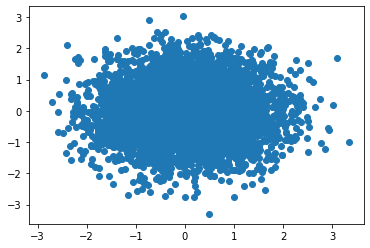

In [ ]:
h = encoderVAEС.predict(x_train[:6000], batch_size=batch_size)    # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[2][:, 0], h[2][:, 1] , )                            # Выводим  скаттер координат точек скрытого пространства
#plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                      # Отрисуем картинку

пространство выглядит неплохо, без явных дыр

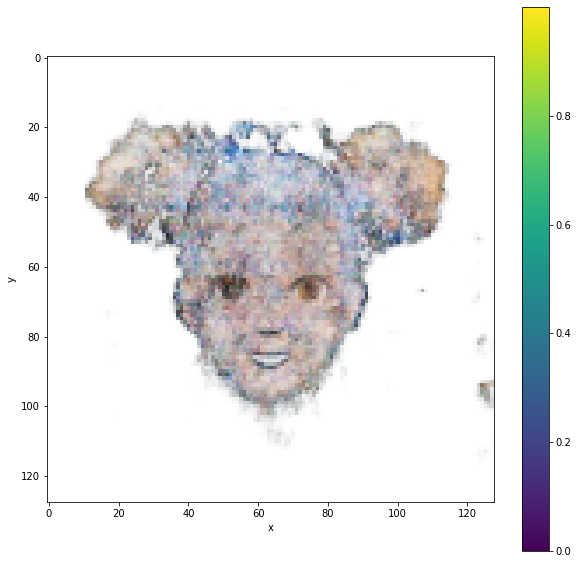

In [ ]:
def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1], z[2], z[3], z[4], z[5], z[6], z[7]]]) #по размеру скрытого пространства, z0 и z1 если =2
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size, 4)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoderVAEС, [2,3, -1, 1, 1.6, 5, 3, 1], 128)

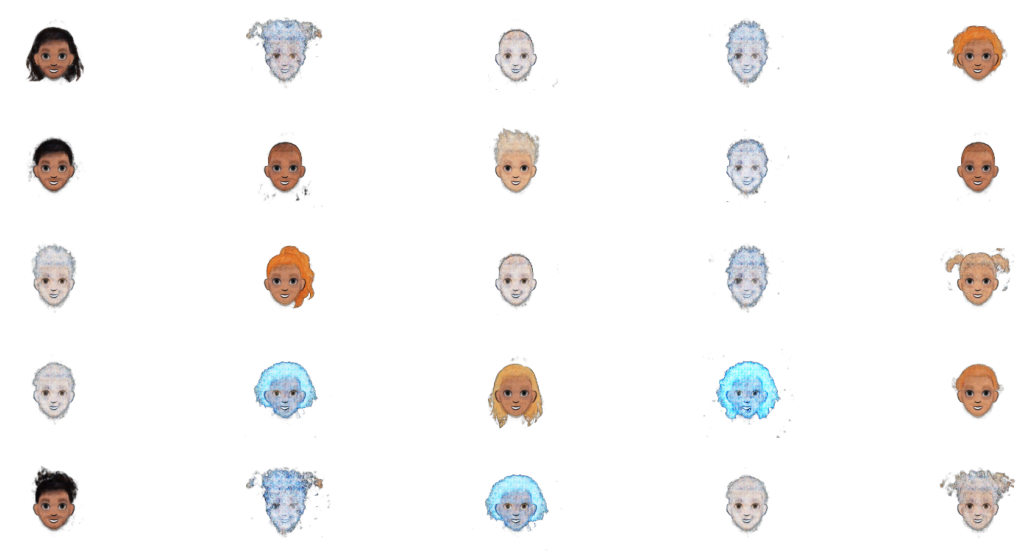

In [ ]:
figsize = 20

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
  #№x1 = np.random.randn()*2 #возьмем случайные точки в латентном пространстве среднее
    #x2 = np.random.randn()
       # матожидание
    ax = fig.add_subplot(5, 5, i+1)

    ax.axis('off')
    data = [np.random.randint(-3,3) for x in range(8)] #случайная генерация точки в скрытом пространстве
    #data = np.array([[xi, yi]])
    data = np.array([data])
    digit = decoderVAEС.predict(data)
    digit = digit.reshape(128, 128, 4)

    ax.imshow(digit)

модель можно дообучать дальше, лосс постепенно уменьшается, картинки становятся более четкими